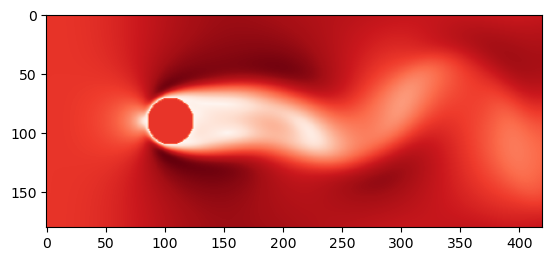

In [2]:
from numpy import *
import matplotlib.pyplot as plt
from matplotlib import cm

###### Flow definition #########################################################
maxIter = 100000  # Total number of time iterations.
Re = 35.0         # Reynolds number.
nx, ny = 420, 180 # Numer of lattice nodes.
ly = ny-1         # Height of the domain in lattice units.
cx, cy, r = nx//4, ny//2, ny//9 # Coordinates of the cylinder.
uLB     = 0.04                  # Velocity in lattice units.
nulb    = uLB*r/Re;             # Viscoscity in lattice units.
omega = 1 / (3*nulb+0.5);    # Relaxation parameter.

###### Lattice Constants #######################################################
v = array([ [ 1,  1], [ 1,  0], [ 1, -1], [ 0,  1], [ 0,  0],
            [ 0, -1], [-1,  1], [-1,  0], [-1, -1] ])
t = array([ 1/36, 1/9, 1/36, 1/9, 4/9, 1/9, 1/36, 1/9, 1/36])

col1 = array([0, 1, 2])
col2 = array([3, 4, 5])
col3 = array([6, 7, 8])

###### Function Definitions ####################################################
def macroscopic(fin):
    rho = sum(fin, axis=0)
    u = zeros((2, nx, ny))
    for i in range(9):
        u[0,:,:] += v[i,0] * fin[i,:,:]
        u[1,:,:] += v[i,1] * fin[i,:,:]
    u /= rho
    return rho, u

def equilibrium(rho, u):              # Equilibrium distribution function.
    usqr = 3/2 * (u[0]**2 + u[1]**2)
    feq = zeros((9,nx,ny))
    for i in range(9):
        cu = 3 * (v[i,0]*u[0,:,:] + v[i,1]*u[1,:,:])
        feq[i,:,:] = rho*t[i] * (1 + cu + 0.5*cu**2 - usqr)
    return feq

###### Setup: cylindrical obstacle and velocity inlet with perturbation ########
# Creation of a mask with 1/0 values, defining the shape of the obstacle.
def obstacle_fun(x, y):
    return (x-cx)**2+(y-cy)**2<r**2

obstacle = fromfunction(obstacle_fun, (nx,ny))

# Initial velocity profile: almost zero, with a slight perturbation to trigger
# the instability.
def inivel(d, x, y):
    return (1-d) * uLB * (1 + 1e-4*sin(y/ly*2*pi))

vel = fromfunction(inivel, (2,nx,ny))

# Initialization of the populations at equilibrium with the given velocity.
fin = equilibrium(1, vel)

###### Main time loop ##########################################################
for time in range(maxIter):
    # Right wall: outflow condition.
    fin[col3,-1,:] = fin[col3,-2,:] 

    # Compute macroscopic variables, density and velocity.
    rho, u = macroscopic(fin)

    # Left wall: inflow condition.
    u[:,0,:] = vel[:,0,:]
    rho[0,:] = 1/(1-u[0,0,:]) * ( sum(fin[col2,0,:], axis=0) +
                                  2*sum(fin[col3,0,:], axis=0) )
    # Compute equilibrium.
    feq = equilibrium(rho, u)
    fin[[0,1,2],0,:] = feq[[0,1,2],0,:] + fin[[8,7,6],0,:] - feq[[8,7,6],0,:]

    # Collision step.
    fout = fin - omega * (fin - feq)

    # Bounce-back condition for obstacle.
    for i in range(9):
        fout[i, obstacle] = fin[8-i, obstacle]

    # Streaming step.
    for i in range(9):
        fin[i,:,:] = roll(
                            roll(fout[i,:,:], v[i,0], axis=0),
                            v[i,1], axis=1 )
 
    # Visualization of the velocity.
    if (time%100==0):
        plt.clf()
        plt.imshow(sqrt(u[0]**2+u[1]**2).transpose(), cmap=cm.Reds)
        plt.savefig("vel.{0:04d}.png".format(time//100))